DATA643- Project 3
======
Prashanth Padebetttu, Parshu Rath, Adjare Windokun, Xingjia Wu
----------
<b> Summer 2016 <br>
Instructor: Andrew Catlin

# Introdocution

We use the Movielens dataset consisting of 100K records as our dataset and use both SVD and TD-IDF to make recommendations and preditions


Load Movielens Data
-------
<b> Load 100K movie data as pandas dataframe:

In [1]:
# Required Python Packages
%matplotlib inline

from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
import csv
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import scipy 
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Load data into a pandas dataframe
# Movielens data with 100,000 records
url = 'https://raw.githubusercontent.com/ppadebettu/CUNY/IS-607-Data-Acquisition-and-Management/IS643/Project_2/movielens.csv'
df = pd.read_csv(url, sep = "," , header = 0, na_values='NaN') # 100000 by 32 dataframe

In [3]:
# Displaying the movielens dataset as a pandas dataframe
df.head()

,userid,age,gender,occupation,zipcode,itemid,rating,timestamp,movieid,movietitle,...,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
0,196,49,M,writer,55105,242,3,881250949,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,186,39,F,executive,00000,302,3,891717742,302,L.A. Confidential (1997),...,0,1,0,0,1,0,0,1,0,0
2,22,25,M,writer,40206,377,1,878887116,377,Heavyweights (1994),...,0,0,0,0,0,0,0,0,0,0
3,244,28,M,technician,80525,51,2,880606923,51,Legends of the Fall (1994),...,0,0,0,0,0,1,0,0,1,1
4,166,47,M,educator,55113,346,1,886397596,346,Jackie Brown (1997),...,0,0,0,0,0,0,0,0,0,0


### Normalization with center mean
The dataset is reduced to only contain the relevant values for the analysis which are the users, items (movies) and ratings.
We then normalize the ratings by subtrating the mean rating of the user from each movie the user has rated

- Normalized dataframe and fill NaN with 0

In [4]:
# convert to wide format for analysis
d = df.pivot_table(index = 'userid', columns = 'movietitle', values = 'rating')
del d.index.name

# normalized dataframe
d_norm1 = d.apply(lambda x: x - x.mean(), axis =1) # row-wise operation
d_norm = d_norm1.fillna(0)

# original dataframe
# d = d.fillna(0)
# d.head()

d_norm.head()

movietitle,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown
1,0.0,0.0,-1.605166,1.394834,0.000000,0.0,-0.605166,0.394834,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.394834,-0.605166,0.0,0.0,0.0,0.394834
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-2.704918,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.000000,-0.773585,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
5,0.0,0.0,-0.874286,0.000000,0.000000,0.0,0.000000,1.125714,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.125714,0.000000,0.0,0.0,0.0,1.125714


In [5]:
# Count non-zero elements in each row
nonzero = d_norm.astype(bool).sum(axis=1).sort_values()
print nonzero.head(12)

644     8
799    13
820    15
369    16
461    16
107    16
772    16
726    17
300    19
736    19
680    19
147    20
dtype: int64


During normalization, if the mean rating of one user equals to the rating of certain movie for that user, the rating of this movie will turn into '0' after normalization. The user whose count is less than 20 are some of such cases. One possible solution is to add small amount to the '0' value before replacing NaN with '0'. From a quick test, we discovered that the replacement NaN with '0' before or after didn't make noticable difference. 

### SVD on user-movie dataframe

In [6]:
U, sigma, V = np.linalg.svd(d_norm, full_matrices=False)
V_df = pd.DataFrame(V, columns=d_norm.columns)

In [7]:
U.shape, V.shape, sigma.shape

((943L, 943L), (943L, 1664L), (943L,))

In [8]:
print (np.round(d_norm - np.dot(U, np.dot(np.diag(sigma), V)), decimals=1)).ix[:10, :3]
# Check the decomposition

movietitle  'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)
1                                 0.0           0.0                    0.0
2                                 0.0           0.0                    0.0
3                                 0.0           0.0                    0.0
4                                 0.0           0.0                    0.0
5                                 0.0           0.0                    0.0
6                                 0.0           0.0                    0.0
7                                 0.0           0.0                    0.0
8                                 0.0           0.0                    0.0
9                                 0.0           0.0                    0.0
10                                0.0           0.0                    0.0


In [12]:
#Display first 20 values of sigma matrix (we can see values in descending order)
sigma[:20]

array([ 81.77388221,  50.45021263,  38.6868671 ,  37.1452392 ,
        35.95574114,  35.32810073,  33.45269439,  31.23301293,
        29.59282607,  29.35679264,  28.41071785,  28.01040805,
        27.90893852,  27.56779631,  27.29434737,  26.92511883,
        26.83001014,  26.42349274,  26.32930402,  25.78858381])

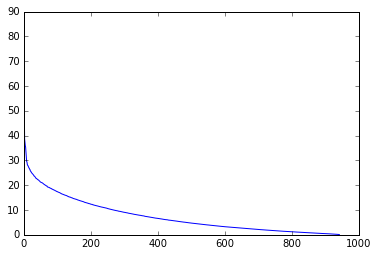

In [13]:
#Plot sigma matrix
plt.plot(sigma)
plt.show()

### Predicted user-item matrix using k features

Find the best k to bulding the approximation matix

In [14]:
# Find k from sigma using arbitrary cutoff value
# Using the L2 norm of the first k elements divided by the L2 norm of all element.
def findK(sigma, cutoff = 0.85):
    totalNorm = np.linalg.norm(sigma)
    for i in range(len(sigma)):
        subNorm = np.linalg.norm(sigma[:i])
        if subNorm/totalNorm >= cutoff:
            return i

In [15]:
print findK(sigma, 0.8)
print findK(sigma, 0.9)
print findK(sigma, 0.95)

126
224
323


We choose 250 as cutoff k value.

In [16]:
k= 250
A_approx = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])

In [17]:
sv = pd.DataFrame(A_approx, columns = d_norm.columns)
sv.index = d_norm.index

In [18]:
print sv.shape
sv.head()

(943, 1664)


movietitle,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown
1,-0.023553,0.008228,-1.565558,1.261832,-0.041160,0.199849,-0.549816,0.398782,0.037906,0.098518,...,-0.037897,0.004088,-0.000641,0.000190,1.426048,-0.604836,-0.217091,-0.076567,-0.080988,0.320088
2,-0.003411,-0.002266,-0.107055,0.019487,0.004608,0.051111,0.073493,0.014156,-0.315652,-0.025292,...,-0.028040,0.003966,0.011367,-0.000015,-0.002923,-0.036912,-0.095013,-0.047812,-0.091993,0.017314
3,-0.000715,-0.008590,0.082044,0.020189,-0.383363,0.133180,-0.047399,-0.133673,-0.019793,-0.006172,...,-0.159633,0.002648,-0.023307,0.000173,-0.009669,0.073363,0.057767,-0.049107,0.064672,-0.040565
4,0.044783,0.016185,-0.009693,-0.058450,0.018618,-0.034808,-0.029456,-0.017743,0.045644,-0.011854,...,0.013467,0.006545,-0.045237,0.000178,-0.056489,-0.003559,0.015279,0.077276,-0.033513,0.007758
5,0.056408,0.012844,-0.743990,0.099311,0.156725,-0.152550,0.061912,1.094953,0.002547,-0.005830,...,0.040879,-0.000822,0.001343,-0.000033,1.125740,0.006329,-0.093931,0.014364,-0.041206,0.961581


### User-User Collaborative Filtering using cosine distance

In [19]:
# function takes in a data frame, what you want to predict pred_id, 
#the type of collaboration, the similarity you want
# to use, and the number of responses you want to get back
## Code adapted from https://blog.liip.ch/archive/2016/06/16/recommender-system-slack-pandas-flask.html

def predict_p(dframe, pred_id, kind = 'user', similarity = cosine_similarity, n = 10):
    d = dframe.fillna(0)
    if kind == 'user':
        dists = similarity(d)
        dists_named = pd.DataFrame(dists, columns = d.index)
        dists_named.index = dists_named.columns
        
    elif kind == 'item':
        d = d.T
        dists = similarity(d)
        dists_named = pd.DataFrame(dists, columns = d.index)
        dists_named.index = dists_named.columns

    p = dists_named[pred_id].sort_values(ascending = False)
    mask = p.index.isin([pred_id])
    p = p[~mask]
    return p[:n]   

<b>Predictions based on user-user cosine distance

In [21]:
#Display other users who are most similar to this user (cosine distane)
predict_p(sv, pred_id = 290, kind = 'user')

70     0.436298
275    0.430113
536    0.313301
901    0.310557
807    0.308049
746    0.307813
545    0.293835
584    0.288945
554    0.284409
162    0.277130
Name: 290, dtype: float64

<b> UU-CF Recommendations

In [22]:
# Recommend items based on User similarity
def get_recommendations_user(predictDF, originalDF, pred_id, similarity = cosine_similarity, n = 10):
    sim = predict_p(predictDF, pred_id = pred_id, n = n) # Top n similarity users
    t = predictDF.ix[sim.index] # Top n closest users with all movie rating
    noRating = pd.isnull(originalDF.ix[pred_id,]) # Find the movies that hasn't been rated by user in originalDF
    p = t.ix[:, noRating[pd.isnull(originalDF.ix[pred_id,])].index] # Top n closest users with movies that were unrated by pred_id
    
    # Calculate the mean rating for the movies
    ratings = p.T.mean(axis = 1).sort_values(ascending = False)[:n]
    return ratings

<b> Get top 10 recommendations (UUCF)

In [23]:
get_recommendations_user(sv, d, 290, 10)

movietitle
Fugitive, The (1993)                 0.474903
Lawrence of Arabia (1962)            0.357959
Titanic (1997)                       0.290488
Air Force One (1997)                 0.254650
Terminator 2: Judgment Day (1991)    0.236563
Wrong Trousers, The (1993)           0.223345
Usual Suspects, The (1995)           0.181232
Face/Off (1997)                      0.180172
Ben-Hur (1959)                       0.179815
Terminator, The (1984)               0.177370
dtype: float64

In [24]:
# Predicted ratings using reduced matrix for user id 290 (note we add mean rating of user back)
r = get_recommendations_user(sv, d, 290, 10)
mean_ratings = d[d.index ==290].mean(axis = 1)
r + float(mean_ratings)

movietitle
Fugitive, The (1993)                 3.828236
Lawrence of Arabia (1962)            3.711292
Titanic (1997)                       3.643821
Air Force One (1997)                 3.607983
Terminator 2: Judgment Day (1991)    3.589897
Wrong Trousers, The (1993)           3.576678
Usual Suspects, The (1995)           3.534566
Face/Off (1997)                      3.533506
Ben-Hur (1959)                       3.533148
Terminator, The (1984)               3.530703
dtype: float64

### Item-Item Collaborative Filtering using cosine distance
Comparison between reduced matrix and original matrix

In [25]:
predict_p(sv, pred_id = "Amadeus (1984)", kind = 'item') # Reduced matrix

movietitle
Schindler's List (1993)                   0.429079
To Kill a Mockingbird (1962)              0.382632
Casablanca (1942)                         0.377062
Citizen Kane (1941)                       0.368342
Henry V (1989)                            0.350346
Shawshank Redemption, The (1994)          0.347318
One Flew Over the Cuckoo's Nest (1975)    0.338533
Godfather, The (1972)                     0.327209
Terminator, The (1984)                    0.311321
Killing Fields, The (1984)                0.310746
Name: Amadeus (1984), dtype: float64

In [92]:
predict_p(d_norm, pred_id = "Amadeus (1984)", kind = 'item') # Original matrix

movietitle
Schindler's List (1993)                   0.398994
Casablanca (1942)                         0.344384
To Kill a Mockingbird (1962)              0.331411
Citizen Kane (1941)                       0.328816
Shawshank Redemption, The (1994)          0.326825
One Flew Over the Cuckoo's Nest (1975)    0.320654
Godfather, The (1972)                     0.309454
Henry V (1989)                            0.296642
Silence of the Lambs, The (1991)          0.287307
Star Wars (1977)                          0.280790
Name: Amadeus (1984), dtype: float64

# TD-IDF

<b>Performing TD-IDF on synopsis of movies (Synopsis data from IMDB)

<b>First we retrieve synopsis for each movie using IMDbPY API 

In [26]:
#Source: http://imdbpy.sourceforge.net/docs/README.package.txt
#To use the IMDbPY package, you've to import the imdb package and call the IMDb function. the basic invocation is:
import imdb
i = imdb.IMDb()
# movie_list is a list of Movie objects, with only attributes like 'title' and 'year' defined.
movie_list = i.search_movie('the passion') #Search for word 'the passion'
# the first movie in the list.
first_match = movie_list[0]
# only basic information like the title will be printed.
print first_match.summary()
movie_list[0]

Movie
=====
Title: Passion of the Christ, The (2004)



<Movie id:0335345[http] title:_The Passion of the Christ (2004)_>

In [32]:
# As an example, get details for movie Title: Passion of the Christ, The (2004)
movie = i.get_movie('0335345') #0335345
print movie['title'] #Get some default information like title
print movie['director'] #Get some default information like director
print movie['genres'] #Get some default information like genre

The Passion of the Christ
[<Person id:0000154[http] name:_Gibson, Mel_>]
[u'Drama']


In [29]:
movie.has_key('demographic') # returns false, since no demographic breakdowns for the movie are available by default.
i.update(movie, info=('vote details',)) # retrieve the vote details info set.
print movie['demographic'] # print the demographic breakdowns.

{u'aged 45+': (18251, 7.2), u'imdb staff': (12, 7.2), u'aged 30-44': (72296, 7.1), u'females': (23839, 7.3), u'females aged 30-44': (9758, 7.2), 'all votes': (178526, 7.1), u'females aged 45+': (3534, 7.7), u'males': (123105, 7.1), u'males aged 18-29': (43762, 7.1), u'males under 18': (243, 7.6), u'aged 18-29': (54012, 7.2), u'males aged 30-44': (61768, 7.1), u'non-us users': (85644, 7.0), u'females aged 18-29': (9847, 7.3), u'us users': (45228, 7.4), u'females under 18': (47, 7.6), u'aged under 18': (294, 7.6), u'top 1000 voters': (673, 6.2), u'males aged 45+': (14455, 7.1)}


In [30]:
i.update(movie, info=('keywords',)) # retrieve the keywords info set.
print movie['keywords'] # print the keywords

[u'based-on-the-bible', u'based-on-biblical-story', u'bible', u'cult-film', u'jerusalem', u'judas', u'trial', u'last-supper', u'pontius-pilate', u'roman', u'crucifixion', u'roman-soldier', u'suffering', u'governor', u'miracle', u'torture', u'temptation', u'disciple', u'betrayal', u'soldier', u'christian', u'box-office-hit', u'roman-empire', u'mel-gibson', u'foot-bath', u'foot-closeup', u'bare-feet', u'grindhouse', u'critically-bashed', u'mercilessness', u'anti-semitism', u'religious-persecution', u'violent-death', u'tortured-to-death', u'scream', u'screaming', u'male-nudity', u'insanity', u'brutality', u'atrocity', u'actual-animal-killed', u'blood-of-christ', u'mob', u'flashback', u'false-accusation', u'controversy', u'english-subtitles-in-original', u'gospel', u'visceral', u'sadism', u'roman-judea', u'eyes-pecked-out', u'ancient-rome', u'spear-through-chest', u'wilderness', u'villain', u'thunderstorm', u'shame', u'severed-finger', u'peril', u'on-the-road', u'nightmare', u'mission', u'

In [31]:
i.update(movie, info=('synopsis',)) # retrieve synopsis about the movie
print movie['synopsis'] # print synopsis

The film opens in Gethsemane in 'medias res as' in the dead of night some hours after the last supper. Jesus prays and is tempted by Satan, while his apostles, Peter, James, and John sleep. After receiving thirty pieces of silver from the highly feared Jewish priests of the Temple in Jerusalem, one of Jesus' other apostles, Judas Iscariot, tells them the location where his teacher is and the priests send a contingent of guards to arrest Jesus for heresy.

In the woods outside Gethsemane, Judas approaches with the temple guards and betrays Jesus with a kiss on his cheek. As the guards move in to arrest Jesus, Peter intervenes and attacks them, cutting off the ear of Malchus, one of the guards, but Jesus tells Peter to stop with the violence and magically heals Malchus' ear. The temple guards arrest Jesus and the rest of the apostles flee.

John runs and tells Jesus' mother, Mary, as well as Mary Magdalene of the arrest, and Peter follows Jesus at a distance who is severely beaten by the

In [33]:
#Download links data that has mapping between different ID's movieid, imdbid and tmdbid
url = 'https://raw.githubusercontent.com/ppadebettu/CUNY/Master/IS_643_Recommender_Systems/Project_3/links.csv'
movie_links = pd.read_csv(url, sep = "," , header = 0, na_values='NaN')
movie_links.columns = ['movieid', 'imdbid', 'tmdbid']
movie_links.head()

,movieid,imdbid,tmdbid
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [34]:
#Merge movielens dataframe and links dataframe, the new dataframe will now have two additional columns towards end
import pandas as pd
newdf = pd.merge(df, movie_links, on='movieid', how='inner')
newdf.head()

,userid,age,gender,occupation,zipcode,itemid,rating,timestamp,movieid,movietitle,...,horror,musical,mystery,romance,scifi,thriller,war,western,imdbid,tmdbid
0,196,49,M,writer,55105,242,3,881250949,242,Kolya (1996),...,0,0,0,0,0,0,0,0,109771,10954.0
1,63,31,M,marketing,75240,242,3,875747190,242,Kolya (1996),...,0,0,0,0,0,0,0,0,109771,10954.0
2,226,28,M,student,92103,242,5,883888671,242,Kolya (1996),...,0,0,0,0,0,0,0,0,109771,10954.0
3,154,25,M,student,53703,242,3,879138235,242,Kolya (1996),...,0,0,0,0,0,0,0,0,109771,10954.0
4,306,45,M,other,73132,242,5,876503793,242,Kolya (1996),...,0,0,0,0,0,0,0,0,109771,10954.0


In [35]:
#Create a cross-reference dataframe that has unique movieid's from the movielense data. This xref df will be used to store other
#key attributes like key words, synopsis etc., from the movies. 
movieid_xref = newdf[['movieid','imdbid']].drop_duplicates()
#movieid_xref = movieid_xref.head(10) #Restrict to 10 movies for now
movieid_xref["keywords"] = ""
movieid_xref["synopsis"] = ""
#movieid_xref.head()
movieid_xref.shape

(1344, 4)

<b>Update xref df with information like key words, synopsis for all movies [Note: This is an expensive http process, ideal to run for few movies first]

In [ ]:
for ind, row in movieid_xref.iterrows():
    movieid = row['imdbid']
    movie = i.get_movie(movieid)
    i.update(movie, info=('keywords',)) # retrieve the keywords info set.
    i.update(movie, info=('synopsis',)) # retrieve the keywords info set.
    movie_keywords = movie['keywords']
    movie_synopsis = movie['synopsis']
    movieid_xref.set_value(ind,'keywords',movie_keywords)
    movieid_xref.set_value(ind,'synopsis',movie_synopsis)
    #print movie_keywords, movie_synopsis
    #print ind, movie['synopsis']  
movieid_xref.head()

In [37]:
#Save data with key words and synopsis by each movie to csv file for TD-IDF processing below
movieid_xref.to_csv('c:\\out.csv', encoding='utf-8')

# Perform TD-IDF on synopsis of movies 

In [40]:
#Load synopsis data with all synopsis 
# Movielens data with 100,000 records
# url = "https://raw.githubusercontent.com/ppadebettu/CUNY/Master/IS_643_Recommender_Systems/Project_3/out.csv"
# df_synopsis = pd.read_csv(url, sep = "," , header = 0, na_values='NaN')

# For testing purposes - will use the above for actual end product
# Query1.csv dataset was generated from out.csv by excluding movies that do not contain synopsis
url = "https://raw.githubusercontent.com/jwindokun/python_assignments/master/Query1.csv"
df_synopsis = pd.read_csv(url, sep = "," , header = 0, na_values='NaN')   

In [39]:
df_synopsis.shape

(735, 5)

In [41]:
df_synopsis.head()

,id,movieid,imdbid,keywords,synopsis
0,414.0,377.0,111257.0,bus bomb explosive rescue elevator lapd ...,In a downtown office building an express elev...
1,553.0,474.0,107206.0,president secret-service secret-service-agen...,Frank Horrigan Clint Eastwood is a Secret Serv...
2,747.0,265.0,103994.0,marriage mexico pubic-hair male-pubic-hair ...,Set in Mexico in 1910Tita Lumi Cavazos and Ros...
3,1059.0,451.0,106926.0,baby girl-in-a-cake derelict-house condom ...,While helping his grifter father burgle a hous...
4,1780.0,222.0,112679.0,circle-of-friends 1950s ireland student th...,This is a charming romance about three girls f...


In [42]:
df_synopsis = df_synopsis[['movieid', 'keywords', 'synopsis']]
df_synopsis.head()

,movieid,keywords,synopsis
0,377.0,bus bomb explosive rescue elevator lapd ...,In a downtown office building an express elev...
1,474.0,president secret-service secret-service-agen...,Frank Horrigan Clint Eastwood is a Secret Serv...
2,265.0,marriage mexico pubic-hair male-pubic-hair ...,Set in Mexico in 1910Tita Lumi Cavazos and Ros...
3,451.0,baby girl-in-a-cake derelict-house condom ...,While helping his grifter father burgle a hous...
4,222.0,circle-of-friends 1950s ireland student th...,This is a charming romance about three girls f...


In [43]:
df_synopsis.head().synopsis.tolist

<bound method Series.tolist of 0    In a downtown office building  an express elev...
1    Frank Horrigan Clint Eastwood is a Secret Serv...
2    Set in Mexico in 1910Tita Lumi Cavazos and Ros...
3    While helping his grifter father burgle a hous...
4    This is a charming romance about three girls f...
Name: synopsis, dtype: object>

In [61]:
#Convert the synopsis to a matrix of TF-IDF features
corpus = df_synopsis['synopsis']
vectorizer = TfidfVectorizer(min_df = 1, norm = 'l2', sublinear_tf = True, analyzer = 'word', stop_words = 'english')
#vectorizer = TfidfVectorizer(min_df = 1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
# print dict(zip(vectorizer.get_feature_names(), idf))
x = pd.DataFrame(X.toarray()).T
y = pd.DataFrame(vectorizer.get_feature_names())
w = pd.concat([y,x], axis = 1)

movieid = df_synopsis['movieid']

#w.columns = ['index', 'a','b','c']
l = pd.Series('index')
movieid = l.append(df_synopsis['movieid'])
w.columns = movieid
w = w.set_index('index')
del w.index.name
w.tail()

,377.0,474.0,265.0,451.0,222.0,1042.0,1184.0,486.0,144.0,1.0,...,1604.0,1625.0,1665.0,1681.0,1675.0,1460.0,1594.0,1645.0,1682.0,1674.0
zinnia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zoe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuko,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
w.head(10)

,377.0,474.0,265.0,451.0,222.0,1042.0,1184.0,486.0,144.0,1.0,...,1604.0,1625.0,1665.0,1681.0,1675.0,1460.0,1594.0,1645.0,1682.0,1674.0
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.202011,0.0,0.0,0.201148,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
10th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#Importance of individual words
w.mean(axis = 1).sort_values(ascending = False)[:25]

film           0.013312
new            0.012093
man            0.010831
young          0.009764
story          0.009276
john           0.009237
old            0.009123
seen           0.008929
opens          0.008854
year           0.008616
plot           0.008373
help           0.008290
title          0.008211
entire         0.008157
movie          0.008122
10             0.008009
short          0.007963
synopsis       0.007930
city           0.007808
include        0.007705
lines          0.007604
normally       0.007596
war            0.007537
description    0.007483
synopses       0.007483
dtype: float64

# Performing SVD on TD-IDF dataset 

In [48]:
U, sigma, V = np.linalg.svd(w, full_matrices=False)
V_df = pd.DataFrame(V, columns=w.columns)

In [49]:
print U.shape
print sigma.shape
print V.shape
print type(sigma)

(7238L, 735L)
(735L,)
(735L, 735L)
<type 'numpy.ndarray'>


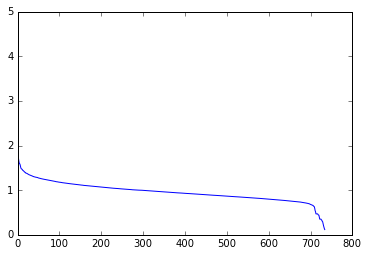

In [50]:
plt.plot(sigma)
plt.show()

In [51]:
sigma[:40]

array([ 4.66333023,  2.38078707,  1.72758917,  1.6550865 ,  1.60526035,
        1.59424306,  1.57244265,  1.53619314,  1.49314849,  1.4788253 ,
        1.47174743,  1.46573132,  1.44813631,  1.44216446,  1.43380916,
        1.42180803,  1.413749  ,  1.40759431,  1.39390974,  1.39347953,
        1.38014467,  1.37852809,  1.3777929 ,  1.37042545,  1.36188104,
        1.35870902,  1.3551957 ,  1.34764761,  1.34390554,  1.34195633,
        1.33822974,  1.3312517 ,  1.32990888,  1.32375089,  1.32255948,
        1.31647615,  1.31334441,  1.30706093,  1.30606153,  1.30040337])

In [52]:
#movieFeature = pd.DataFrame(movieFeature)
#movieFeature.shape
print findK(sigma, 0.8)
print findK(sigma, 0.9)
print findK(sigma, 0.95)

346
494
591


In [94]:
# Choosing 500 as cut off

In [53]:
k= 500
A_approx = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])

In [54]:
sv = pd.DataFrame(A_approx, columns = w.columns)
sv.index = w.index

In [54]:
sv.head()

,377.0,474.0,265.0,451.0,222.0,1042.0,1184.0,486.0,144.0,1.0,...,1604.0,1625.0,1665.0,1681.0,1675.0,1460.0,1594.0,1645.0,1682.0,1674.0
00,-0.002266,0.026162,-0.000006,0.003748,0.001688,0.000231,-0.002778,-0.000341,-0.003176,-0.001361,...,0.000080,0.006468,0.019142,0.000332,-0.000471,-0.000485,-0.002527,0.001365,-0.002695,0.001598
000,0.010559,-0.003104,0.000727,0.008278,-0.002248,-0.008313,0.014205,0.012997,0.008363,-0.006011,...,0.000759,-0.000023,-0.001748,-0.001233,0.000311,0.002474,0.003576,-0.011334,-0.005091,0.003781
10,-0.003792,-0.001833,-0.005372,0.007424,-0.000613,0.004317,0.006908,-0.003784,0.000192,0.001323,...,0.201506,0.006438,-0.000929,0.200388,-0.004780,-0.001697,0.000643,0.003764,-0.000265,0.001660
100,0.001021,0.004821,-0.007901,0.000588,0.000018,0.001910,0.000341,-0.002489,-0.001384,-0.002175,...,0.000134,0.000294,-0.003797,-0.000189,0.002505,-0.000378,-0.000731,-0.001248,0.000628,-0.000467
1000,-0.015517,-0.005023,-0.005087,0.004099,0.003251,0.006874,0.003125,-0.002798,-0.012201,0.002541,...,-0.000180,-0.000818,0.007374,-0.000878,-0.002666,0.004302,0.003383,0.007348,-0.001565,0.004702


In [55]:
sv = sv.T

In [56]:
sv.head()


,00,000,10,100,1000,10000,10th,11,112,11th,...,zealand,zed,zelda,zero,zeus,zinnia,zinone,zoe,zone,zuko
377.0,-0.002266,0.010559,-0.003792,0.001021,-0.015517,-0.002817,0.003682,0.010816,-0.003689,-0.001569,...,-0.008938,0.006613,-0.001986,0.003249,-0.002308,0.007035,-0.000506,-0.000900,-0.003333,-0.002261
474.0,0.026162,-0.003104,-0.001833,0.004821,-0.005023,-0.001130,0.001830,0.012335,0.005497,0.000603,...,0.018678,0.004517,0.004702,0.009071,-0.003686,0.000945,0.005551,0.004747,0.013401,0.003184
265.0,-0.000006,0.000727,-0.005372,-0.007901,-0.005087,0.001128,0.000016,0.008272,0.006922,-0.004705,...,0.002866,-0.002825,0.002479,0.002868,-0.002916,0.000049,-0.000283,0.000340,0.000431,-0.002521
451.0,0.003748,0.008278,0.007424,0.000588,0.004099,-0.000442,0.001653,-0.001773,0.006334,-0.003357,...,-0.010615,-0.001978,-0.000632,0.001893,0.001833,0.001025,0.003544,-0.003332,-0.000970,-0.001907
222.0,0.001688,-0.002248,-0.000613,0.000018,0.003251,0.002021,0.003420,0.002749,0.002613,0.000919,...,-0.007263,0.002234,-0.001132,0.007571,0.000525,0.002940,-0.001041,-0.002298,-0.005556,-0.005402


In [57]:
# Select a movie to predict, will movie with Movie ID = 474
df[df.movieid == 474].movietitle[:1]

5    Dr. Strangelove or: How I Learned to Stop Worr...
Name: movietitle, dtype: object

In [58]:
p_movie = predict_p(sv, pred_id = 474, kind = 'user')

In [59]:
p_movie = pd.DataFrame(p_movie)
print p_movie
p_movie.index

            474.0
 10.0    0.261022
 1266.0  0.231420
 1292.0  0.193675
 1255.0  0.187658
 1260.0  0.151798
NaN      0.149779
 1382.0  0.144471
 784.0   0.143918
 635.0   0.143603
 1586.0  0.129981


Index([10.0, 1266.0, 1292.0, 1255.0, 1260.0, nan, 1382.0, 784.0, 635.0,
       1586.0],
      dtype='object')

In [60]:
pd.DataFrame(df[df['movieid'].isin(p_movie.index)].movietitle.unique())

,0
0,Richard III (1995)
1,Total Eclipse (1995)
2,Bread and Chocolate (Pane e cioccolata) (1973)
3,"Fog, The (1980)"
4,"Simple Wish, A (1997)"
5,Beyond Bedlam (1993)
6,Lashou shentan (1992)
7,Broken English (1996)
8,"Bonheur, Le (1965)"


### Summary

- In this project, singular value decomposition (SVD) was applied on normalized user-item matrix (943X1664). Dimension reduction was performed by setting k = 250. The user-item matrix was reconstructed for predicted rating.
<hr>
- User-User and Iterm-Iterm collaborative filtering systems were built to give recommendations.
<hr>
- Information, including synopsis, keywords, taglines etc., of each movie were retrieved using IMDbPY API. 
<hr>
- Both the synopsis and keywords were converted to a matrix of TF-IDF features using sklearn.feature_extraction.text.TfidfVectorizer. After transforming, the matrices of tfidf were built.  
<hr>
- The matrix of synopsis was decomposited by SVD. After reconstruction of this matrix (k=500), the cosine similarity matrix was built. This matrix is the basis for content-based recommendation system. 
<hr>
- Future work: The matrix of tfidf can further be trained for  features, we can train a classifier to try to predict the category of a post